In [1]:
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
import numpy as np

from sklearn.metrics import accuracy_score

In [2]:
df = pd.read_csv("heart.csv")

print(df.head())

   Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F           NAP        160          180          0     Normal    156   
2   37   M           ATA        130          283          0         ST     98   
3   48   F           ASY        138          214          0     Normal    108   
4   54   M           NAP        150          195          0     Normal    122   

  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0              N      0.0       Up             0  
1              N      1.0     Flat             1  
2              N      0.0       Up             0  
3              Y      1.5     Flat             1  
4              N      0.0       Up             0  


In [5]:
label_encoder = LabelEncoder()
df['Sex'] = label_encoder.fit_transform(df['Sex'])
df['ChestPainType'] = label_encoder.fit_transform(df['ChestPainType'])
df['RestingECG'] = label_encoder.fit_transform(df['RestingECG'])
df['ExerciseAngina'] = label_encoder.fit_transform(df['ExerciseAngina'])
df['ST_Slope'] = label_encoder.fit_transform(df['ST_Slope'])

print(df.head())

   Age  Sex  ChestPainType  RestingBP  Cholesterol  FastingBS  RestingECG  \
0   40    1              1        140          289          0           1   
1   49    0              2        160          180          0           1   
2   37    1              1        130          283          0           2   
3   48    0              0        138          214          0           1   
4   54    1              2        150          195          0           1   

   MaxHR  ExerciseAngina  Oldpeak  ST_Slope  HeartDisease  
0    172               0      0.0         2             0  
1    156               0      1.0         1             1  
2     98               0      0.0         2             0  
3    108               1      1.5         1             1  
4    122               0      0.0         2             0  


In [6]:
from sklearn.model_selection import train_test_split

X = df.iloc[:, :-1]
y = df.iloc[:, -1]

y = 2 * y - 1

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.33, random_state=42)

In [7]:
import numpy as np

class DecisionStump:
    def __init__(self):
        self.feature_index = None
        self.threshold = None
        self.left_label = None
        self.right_label = None

    def fit(self, X, y):
        X = X.values

        n_samples, n_features = X.shape
        best_gain = -1

        for feature_index in range(n_features):
            thresholds = np.unique(X[:, feature_index])

            for threshold in thresholds:
                left_mask = X[:, feature_index] <= threshold
                right_mask = X[:, feature_index] > threshold

                if np.sum(left_mask) == 0 or np.sum(right_mask) == 0:
                    continue

                gain = self._information_gain(y, y[left_mask], y[right_mask])

                if gain > best_gain:
                    best_gain = gain
                    self.feature_index = feature_index
                    self.threshold = threshold
                    self.left_label = self._majority_vote(y[left_mask])
                    self.right_label = self._majority_vote(y[right_mask])

    def predict(self, X):
        X = X.values

        left_mask = X[:, self.feature_index] <= self.threshold
        right_mask = X[:, self.feature_index] > self.threshold

        y_pred = np.zeros(X.shape[0], dtype=int)
        y_pred[left_mask] = self.left_label
        y_pred[right_mask] = self.right_label

        return y_pred

    def _entropy(self, y):
        _, counts = np.unique(y, return_counts=True)
        probabilities = counts / len(y)
        return -np.sum(probabilities * np.log2(probabilities + 1e-10))

    def _information_gain(self, parent_y, left_y, right_y):
        parent_entropy = self._entropy(parent_y)

        left_entropy = self._entropy(left_y)
        right_entropy = self._entropy(right_y)

        n_left = len(left_y)
        n_right = len(right_y)
        n_total = len(parent_y)
        weighted_entropy = (n_left / n_total) * left_entropy + (n_right / n_total) * right_entropy

        gain = parent_entropy - weighted_entropy
        return gain

    def _majority_vote(self, y):
        if len(y) == 0:
            return 0
        unique_labels, counts = np.unique(y, return_counts=True)
        return unique_labels[np.argmax(counts)]

In [8]:
class Adaboost:
    def __init__(self):
        self.alphas = []
        self.models = []


    def fit(self, X, y):
        rounds = [50, 100, 150]
        best_round_size = 50
        best_accuracy = 0

        for round_size in rounds:
            self.alphas = []
            self.models = []

            self.fit_with_rounds(X, y, round_size)
            prediction = self.predict(X_val)
            model_accuracy = accuracy_score(y_val, prediction)

            if model_accuracy > best_accuracy:
                best_accuracy = model_accuracy
                best_round_size = round_size

        self.alphas = []
        self.models = []
        self.fit_with_rounds(X, y, best_round_size)


    def fit_with_rounds(self, X, y, rounds):
        n_samples, _ = X.shape
        w = np.ones(n_samples) / n_samples

        for _ in range(rounds):
            model = DecisionStump()
            model.fit(X, y)

            predictions = model.predict(X)

            err = np.sum(w * (y != predictions)) / np.sum(w)
            alpha = 0.5 * np.log((1 - err)/(err + 1e-10))

            self.alphas.append(alpha)
            self.models.append(model)

            w = w * np.exp(-alpha * y * predictions)
            w = w / np.sum(w)



    def predict(self, X):
        predictions = np.zeros(X.shape[0])

        for model, alpha in zip(self.models, self.alphas):
            predictions += (model.predict(X)) * alpha

        return np.sign(predictions).astype(int)



In [9]:
adaboost = Adaboost()
adaboost.fit(X_train, y_train)
predictions = adaboost.predict(X_test)

In [10]:
accuracy = accuracy_score(y_test, predictions)
print(f"accuracy is {accuracy}")

accuracy is 0.7934782608695652


In [11]:
from sklearn.metrics import f1_score

score = f1_score(y_test, predictions, average=None)
print(f"f1 socre is {score}")

f1 socre is [0.7654321  0.81553398]


In [12]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, predictions)
print(cm)

[[62 17]
 [21 84]]


In [13]:
%pip install seaborn

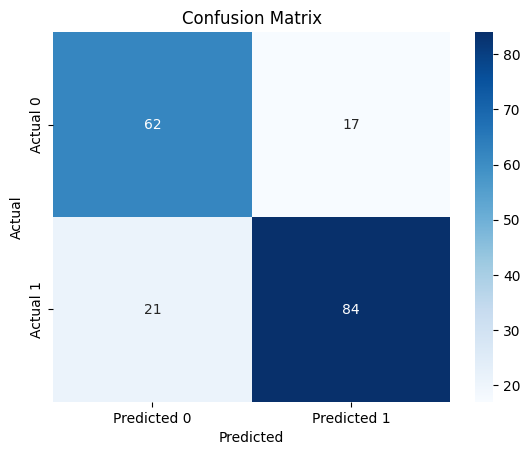

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()